#### Neural Language Model (MLP-based) from Scratch

Epoch   0 | Loss: 2.5700
Epoch  50 | Loss: 1.0365
Epoch 100 | Loss: 0.9474
Epoch 150 | Loss: 0.9211
Epoch 200 | Loss: 0.9029
Epoch 250 | Loss: 0.8880


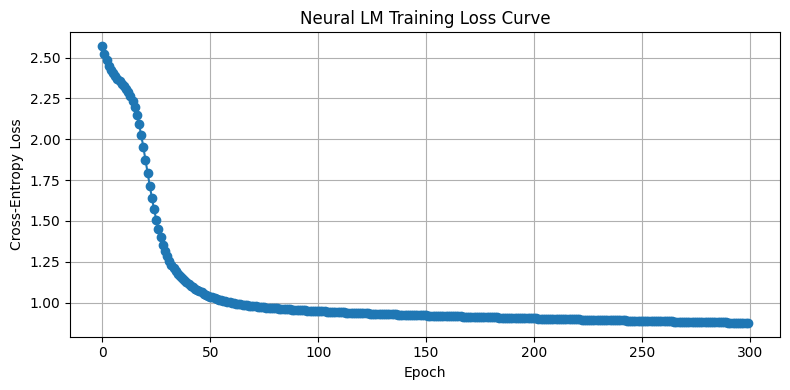


Generated Text:
hello world hello hello hello world hello world hello world hello hello world hello world
language models are powerful lowest lower lowest lower lowest lower lowest lower lowest world hello
low lower lowest hello world hello hello world hello hello hello world hello hello hello

Neural LM Perplexity: 1.9894779941434702


In [ ]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import Counter

# Corpus
corpus = [
    "low lower lowest",
    "newer newer newest",
    "low newest lower",
    "hello world hello hello",
    "language models are powerful"
]

# Tokenization & Vocabulary
def tokenize(text):
    return ["<s>"] + text.lower().split() + ["</s>"]

all_tokens = []
for sentence in corpus:
    all_tokens.extend(tokenize(sentence))

vocab = sorted(set(all_tokens))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(vocab)

# Build Training Data (Bigram Context)
X = []
Y = []

for sentence in corpus:
    tokens = tokenize(sentence)
    for i in range(len(tokens) - 1):
        X.append(word2idx[tokens[i]])
        Y.append(word2idx[tokens[i + 1]])

X = np.array(X)
Y = np.array(Y)

# Model Parameters
embedding_dim = 16
hidden_dim = 32
learning_rate = 0.05
epochs = 300

rng = np.random.default_rng(42)

E = rng.normal(0, 0.1, (vocab_size, embedding_dim))
W1 = rng.normal(0, 0.1, (embedding_dim, hidden_dim))
b1 = np.zeros(hidden_dim)
W2 = rng.normal(0, 0.1, (hidden_dim, vocab_size))
b2 = np.zeros(vocab_size)

# Helper Functions
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)

def forward(x_idx):
    embed = E[x_idx]                 # (embedding_dim,)
    h = np.tanh(embed @ W1 + b1)     # (hidden_dim,)
    logits = h @ W2 + b2             # (vocab_size,)
    probs = softmax(logits)
    return embed, h, probs

def cross_entropy_loss(probs, y_idx):
    return -math.log(probs[y_idx] + 1e-9)

# Training Loop
losses = []

for epoch in range(epochs):
    total_loss = 0

    for x_idx, y_idx in zip(X, Y):
        # Forward
        embed, h, probs = forward(x_idx)
        loss = cross_entropy_loss(probs, y_idx)
        total_loss += loss

        # Backward
        dlogits = probs.copy()
        dlogits[y_idx] -= 1           # softmax + CE gradient

        dW2 = np.outer(h, dlogits)
        db2 = dlogits

        dh = W2 @ dlogits
        dh_raw = dh * (1 - h**2)      # tanh derivative

        dW1 = np.outer(embed, dh_raw)
        db1 = dh_raw

        dE = W1 @ dh_raw

        # Update
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        E[x_idx] -= learning_rate * dE

    avg_loss = total_loss / len(X)
    losses.append(avg_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f}")

# Visualization: Training Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(losses, marker="o")
plt.title("Neural LM Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Text Generation
def generate_text(start_token="<s>", max_len=15, temperature=0.8):
    word = start_token
    generated = []

    for _ in range(max_len):
        x_idx = word2idx[word]
        _, _, probs = forward(x_idx)

        # Avoid ending too early
        probs[word2idx["</s>"]] = 0

        # Apply temperature
        probs = np.log(probs + 1e-9) / temperature
        probs = np.exp(probs) / np.sum(np.exp(probs))

        next_idx = np.random.choice(len(probs), p=probs)
        next_word = idx2word[next_idx]

        generated.append(next_word)
        word = next_word

    return " ".join(generated)

print("\nGenerated Text:")
print(generate_text())
print(generate_text(temperature=0.7))
print(generate_text(temperature=1.2))


# Perplexity Evaluation
def neural_lm_perplexity(sentence):
    tokens = tokenize(sentence)
    log_prob_sum = 0

    for i in range(len(tokens) - 1):
        x_idx = word2idx.get(tokens[i], None)
        y = tokens[i + 1]
        if x_idx is None or y not in word2idx:
            prob = 1e-9
        else:
            _, _, probs = forward(x_idx)
            prob = probs[word2idx[y]]
        log_prob_sum += math.log(prob + 1e-9)

    N = len(tokens) - 1
    return math.exp(-log_prob_sum / N)

test_sentence = "low newest lower"
print("\nNeural LM Perplexity:", neural_lm_perplexity(test_sentence))
